# TED Talk Clustering

>I watched a [TED Talk](https://www.ted.com/talks) yesterday.  

Everyone knows what you mean when you say that.  The TED organization has created conferences for experts in widely-varying fields to espouse their ideas. Fundamentally, the talks are 5-18 minute presentations about _big_ topics.  Mental health, space travel, AIDS, systemic racism, artificial intelligence.  They are _Ideas worth spreading™_.  TED Talks are not rote lectures, nor are they pointed dissections of a given problem.  Usually, speakers weave in personal or relatable stories through their narratives as an empathetic call to action for the audience.  This presentation device makes these big topics digestible, shareable.  It also is what drives the popularity, and sometimes, the virality, of TED Talks.  

Some (most?) TED talks defy easy categorization.  A single talk could cover everything from criminal justice reform, police brutality, systemic racism, racial inequity in public education, poor maternal prenatal nutrition, and food deserts.  Or it could be about [replying to email spammers](https://www.youtube.com/watch?v=_QdPW8JrYzQ).

What are the types of topics covered by TED Talks?  Are some topics more popular than others?  How can we measure "popularity" of a topic?  Let's try to answer these questions.


# Workflow

At a high-level, our efforts will focus on collecting the relevant data, embedding the talk transcripts in a vector form through the [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) algorithm, decomposing this vector down to 2 dimensions, perform clustering, and finally evaluating the popularity of each cluster.  This workflow will notionally take us from raw text, to vector-space, to clusters of specific topical talks.

First, we'll need to get transcripts of a bunch of TED Talks.  Using the official [YouTube API](https://developers.google.com/youtube/v3/getting-started) (and some manual efforts) I grabbed 517 TED Talk YouTube video ids and stats.  These stats were view count, likes, dislikes, and comments.  Next we'll pass the video ids to [youtube-transcript-api](https://pypi.org/project/youtube-transcript-api/) to get each talk's transcript.  

After we have the transcripts, we pass them through the **doc2vec** algorithm.  The output from this model is a 500-term vector which will provide us some semantic understanding of each transcript.  Hopefully, these vectors encode both a level of topical representation at both broad and fine scales.  If this is, indeed, the case, then we should be able to do a clustering analysis to arrive at groups of talks with similar topics.

Finally, we will create a popularity metric to compare each topic's average popularity.  


# Data ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import random

from youtube_transcript_api import YouTubeTranscriptApi as YTT

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabaz_score, davies_bouldin_score

%matplotlib inline
sns.set_style('white')
r = 2315      # random state seed

In [2]:
# Read in all video ids
all_vids = pd.read_csv('FiveHundredTedTalks.csv', index_col = 0)
print(all_vids.shape)
all_vids.head()

(517, 8)


,ids,title,tags,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
0,_QdPW8JrYzQ,This is what happens when you reply to spam em...,"['TED Talk', 'TED Talks', 'James Veitch', 'spa...",38997637,807239,24122,0,21041
1,eIho2S0ZahI,How to speak so that people want to listen | J...,"['TEDTalk', 'TEDTalks', 'TED Talk', 'TED Talks...",21310172,340364,6920,0,5580
2,arj7oStGLkU,Inside the mind of a master procrastinator | T...,"['TED Talk', 'TED Talks', 'Tim Urban', 'procra...",20716136,710320,7274,0,32100
3,KM4Xe6Dlp0Y,"Looks aren&#39;t everything. Believe me, I&#39...","['TEDTalk', 'TEDTalks', 'TED Talk', 'TED Talks...",18213865,281106,11981,0,16077
4,iG9CE55wbtY,Do schools kill creativity? | Sir Ken Robinson,"['Ken', 'Robinson', 'TED', 'TEDTalks', 'Talks'...",17158762,175167,2940,0,9810


Here is the raw data collected from the official YouTube API.  Note that we do have `tags` which I believe to be manually created tags from the TED Talk channel when they uploaded each individual video. 

In [3]:
# def cleaner(text):
#     '''
#     Cleans all transcripts
#     '''
#     out = re.sub('(Reviewer: \w+ \w+\W\w+)', '', text)
#     out = re.sub('(Translator: \w+ \w+)', '', out)
#     out = re.sub('(\w+:)', '', out)
#     out = re.sub('(\s)', ' ', out)
#     out = re.sub(r'\n', ' ', out)
#     out = re.sub('(\[.+\])', '', out)
#     out = re.sub('(\()\S+', '', out)
#     out = re.sub('--', ' ', out)
#     out = re.sub('  ', ' ', out)
#     out = re.sub('   ', ' ', out)
#     return out

        
# def YTTranscript(yt_id):
#     '''
#     Uses the unofficial youtube_transcript_api to pull transcripts.
#     Sends transcripts to the cleaner function. 
#     '''
#     transcript = []
#     try:
#         text = YTT.get_transcript(yt_id, languages=['en'])
#         for t in text:
#             transcript.append(t['text'])
#         join_text = ' '.join(transcript)
#         clean_text = cleaner(join_text)
#         return clean_text
#     except:
#         # For videos which fail to return a transcript
#         return np.NaN


In [4]:
# # Pull all transcripts and clean them
# all_vids['transcript'] = all_vids['ids'].apply(lambda x: YTTranscript(x))

# # Drop videos that didn't have transcripts available
# all_vids.dropna(axis=0, subset=['transcript'], inplace=True)

# all_vids.to_csv('./TedTalkTranscripts/all_vids_transcripts.csv')

In [5]:
df_vid = pd.read_csv('./TedTalkTranscripts/all_vids_transcripts.csv', index_col = 0)

In [6]:
def tag_cleaner(tags):
    '''
    Processed YouTube tags and returns a clean list.
    Removes 'TED'-centric tags. 
    '''
    clean_tags = []
    out_tags = []

    tags_words = tags.split(sep=',')
    for word in tags_words:
        clean_tags.append(re.sub('\W+', '', word))
        
    for w in clean_tags:
        if w[:3].lower() != 'ted':
            out_tags.append(w)
            
    return out_tags


df_vid['clean_tags'] = df_vid['tags'].apply(lambda x: tag_cleaner(x))
print(df_vid.shape)
df_vid.sample(5)

(514, 10)


,ids,title,tags,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,transcript,clean_tags
14,iCvmsMzlF7o,The power of vulnerability | Brené Brown,"['Brene', 'Brown', 'TEDTalks', 'TED', 'talks',...",10422272,128424,2858,0,2823,"So, I'll start with a couple years ago, an eve...","[Brene, Brown, talks, vulnerability, psycholog..."
399,Xj-ncWb4N-I,How do we learn to work with intelligent machi...,"['TEDTalk', 'TEDTalks', 'technology', 'AI', 'a...",57329,1141,52,0,99,"It’s 30 in the morning, and Kristen is wheelin...","[technology, AI, artificialintelligence, compu..."
197,0gks6ceq4eQ,You aren&#39;t at the mercy of your emotions -...,"['TEDTalk', 'TEDTalks', 'Emotions', 'Brain', '...",877345,19647,709,0,1123,My research lab sits about a mile from where s...,"[Emotions, Brain, Humanity, PersonalGrowth, Sc..."
5,c73Q8oQmwzo,How boredom can lead to your most brilliant id...,"['TEDTalk', 'TEDTalks', 'Brain', 'Cognitive sc...",330696,9149,259,0,406,My son and the iPhone were born three weeks ap...,"[Brain, Cognitivescience, Communication, Creat..."
276,-Z-vyLHi2us,Our natural sleep cycle | Jessa Gamble,"['Jessa', 'Gamble', 'TEDTalks', 'TED', 'talks'...",418855,1930,379,0,328,Let's start with day and night. Life evolved u...,"[Jessa, Gamble, talks, sleep, sleeping, cycle,..."


After passing the video ids to `youtube-transcript-api` and cleaning the results, we end up with clean transcripts.  Now we can vectorize them.

# doc2vec

Let's take a moment to discuss the **doc2vec** algorithm and why we are using it.  At it's core, **doc2vec** is a way to numerically represent a document of text.  Similar to *word2vec* it uses a sliding window around a given word to capture that word's context.  The words it occurs near (or not near, in some cases) provide a numeric representation of the that word's semantics.  However, the *word2vec* model is constrained to individual sentences.  That is, it can't know what came before or after a particular sentence.  It can't provide semantic representation of an entire document.  **doc2vec** reads, processes, and vectorizes entire documents, irrespective of sentence structure.  Because of this, we should be able to get a semantic understanding of each document as whole.  The hope is that these semantic vectors will provide good material to cluster the talks on, into common topics.

For our purposes, this is a fully unsupervised approach. We have no predetermined labels that we are going to test against.  The goal here is to cluster on topics that are unknown to us.


## Preprocessing

In [7]:
# Splitting into train/test samples.
X = df_vid['transcript']
X_train, X_test = train_test_split(X, random_state=r)

In [8]:
# Tagging the document for Doc2Vec model preprocessing.
X_tagged = []
for i, trans in enumerate(X_train):
    X_tagged.append(TaggedDocument(simple_preprocess(trans), [i]))
    
# Need the Test transcripts in a list
X_test_list = []
for trans in X_test:
    X_test_list.append(simple_preprocess(trans))

In [9]:
# Pulling indices for the train & test splits. This will make translating back to 
# the original dataframe easier.  For instance, we will want to see the 
# YouTube video stats.
X_train_idx = []
for idx in X_train.index:
    X_train_idx.append(idx)

X_test_idx = []
for idx in X_test.index:
    X_test_idx.append(idx)

# Pulling video tags for the train & test splits
train_labels = []
for i in range(0, len(X_tagged)):
    train_labels.append(df_vid.iloc[X_train_idx[i], 9])
    
test_labels = []
for i in range(0, len(X_test_idx)):
    test_labels.append(df_vid.iloc[X_test_idx[i], 9])


## Model Building

The **doc2vec** algorithm has a bunch of hyperparameters.  I've kept this implemenation fairly simple but have grid searched (see grid search section) through a wide variety of potential solutions.  These hyperparameters tend to result in good human reading results and mediocre clustering results.

I liberally referenced the [gensim tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb) while initially setting up and testing the model.

In [10]:
# Instantiate, build a vocab, and train the model
# Hyperparameters have been grid searched and optimized
# See `Grid Search` section below

model = Doc2Vec(vector_size=500,  # Output vector size
                min_count=3,      # Minimum word count, ignores less frequent words
                epochs=100,       # Model runs for 100 epochs
                window=100,       # Use a sliding window 100 words wide
                dm=0,             # Use a distributed bag of words approach, AKA skip-gram
                workers=4,        # Number of cores to use
                seed=r)           # Random seed
model.build_vocab(X_tagged)
model.train(X_tagged, total_examples=model.corpus_count, epochs=model.epochs)

Because this is a truly unsupervised approach, we need to manually compare the talk transcripts.  To achieve this comparison, we use the `.most_similar()` method to find the most similar and second most similar documents.  The most similar training talk is going to be itself because this is a small (in number of talks) corpus and we've used 100 training epochs.  The second most similar talk should be the talk, other than itself, which is most similar to a given talk.  

In [11]:
# Testing the model against itself. Seeing what the most 
# similar predicted document is for each in the training set.

ranks = []
second_ranks = []

for doc_id in range(len(X_tagged)):
    # Generates an inferred vector from the transcript
    inferred_vector = model.infer_vector(X_tagged[doc_id].words)

    # Gets the most similar vectors to the inferred
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)

    # Stores the index of the most similar vector
    ranks.append(rank)
    # Stores the index of the second most similar vector
    second_ranks.append(sims[1])

In [12]:
# Essential invoking a confusion matrix.
Counter(ranks)

Counter({0: 385})

The model is perfectly trained on itself - it accurately predicts each document in the training set.  If it didn't, the counter would have been something like: `Counter({0:365, 1:20})`. This would've indicated that 20 texts were misclassified.  It's unknown whether our result means the model is overfit.

Now let's see what the second most similar text is for a given training document.


# Model Testing

What we'll do here is pick a random document from the training set and then get it's second-most similar training set talk transcript.  For each, we'll show the YouTube tags and the first 1,000 words.  The similar document will also have the cosine distance score.  It'll be up to our human intuition to determine if the model is picking a similar talk.  

In [13]:
# Pick a random document from the corpus and infer a vector from the model
doc_id = random.randint(0, len(X_tagged) - 1)
train_label = df_vid.iloc[X_train_idx[doc_id], 9]

# Print the random training document
print('Train Document ({}, {}):\n «{}»\n'.format(doc_id, 
                                               train_label, 
                                               ' '.join(X_tagged[doc_id][0][:250])))

# Compare and print the second-most-similar document, because the most similar
# document is the document itself
sim_id = second_ranks[doc_id]
sim_label = df_vid.iloc[X_train_idx[sim_id[0]], 9]
print('Similar Document ({}, {}):\n «{}»\n'.format(sim_id, 
                                           sim_label, 
                                           ' '.join(X_tagged[sim_id[0]][0][:250])))

Train Document (154, ['JulieLythcottHaims', 'Stanford', 'children', 'education', 'college', 'collegerankings', 'school', 'learning', 'teaching', 'HowtoRaiseanAdult']):
 «think of hard choice you ll face in the near future it might be between two careers artist and accountant or places to live the city or the country or even between two people to marry you could marry betty or you could marry lolita or it might be choice about whether to have children to have an ailing parent move in with you to raise your child in religion that your partner lives by but leaves you cold or whether to donate your life savings to charity chances are the hard choice you thought of was something big something momentous something that matters to you hard choices seem to be occasions for agonizing hand wringing the gnashing of teeth but think we ve misunderstood hard choices and the role they play in our lives understanding hard choices uncovers hidden power each of us possesses what makes choice hard is the 

## Training set -- Most similar doc comparison

For the most part, the most similar training document seems fairly similar to the random training document. 


## Testing set comparison

Now let's test the model on the hold-out set. We'll compare the test document against the most similar training text.

In [14]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(X_test_list) - 1)
inferred_vector = model.infer_vector(X_test_list[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

test_label = df_vid.iloc[X_test_idx[doc_id], 9]
sim_label = df_vid.iloc[X_train_idx[sims[0][0]], 9]
sim_trans = df_vid.iloc[X_train_idx[sims[0][0]], 8]

# Print the Test document and the most similar training document
print("Test Document ({}, {}):\n «{}»\n".format(doc_id, 
                                                test_label, 
                                                ' '.join(X_test_list[doc_id])[:1000]))

print("Most Similar ({}, {}):\n «{}»".format(sims[0], 
                                             sim_label, 
                                             sim_trans[:1000]))


Test Document (46, ['CosminMihaiu', 'demo', 'gaming', 'health', 'software']):
 «admin do you guys think for those who watched sir ken memorable ted talk am typical example of what he describes as the body as form of transport for the head university professor you might think it was not fair that ve been lined up to speak after these first two talks to speak about science can move my body to the beat and after scientist who became philosopher have to talk about hard science it could be very dry subject yet feel honored never in my career and it been long career have had the opportunity to start talk feeling so inspired like this one usually talking about science is like exercising in dry place however ve had the pleasure of being invited to come here to talk about water the words water and dry do not match right it is even better to talk about water in the amazon which is the splendid cradle of life fresh life so this is what inspired me that why here although carrying my head over here

## Test set -- Most similar doc comparison

The test results don't show that much similarity, however, there definitely is some overlap of topics.


Let's grab each video's `docvec` and project the data down to two dimensions using t-SNE to analyze how these videos are being clustered.

# Assessing doc2vec via clustering

In [15]:
# Storing the doc2vec vector to DataFrame
df_docvec = pd.DataFrame([model.docvecs[i] for i in range(len(X_tagged))])

print(df_docvec.shape)
df_docvec.head() 

(385, 500)


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.156893,-0.532260,0.156471,0.149597,0.012316,-0.044525,0.256031,-0.168451,0.183777,0.135660,...,-0.604077,0.048369,0.285411,-0.152690,-0.215297,0.284091,-0.348495,0.058978,0.414641,-0.253151
1,-0.425103,-0.541359,-0.308025,0.066946,0.062147,-0.038958,-0.328966,0.079851,0.022513,-0.316607,...,0.223895,-0.322064,0.108260,-0.481957,-0.040428,-0.185878,-0.210720,-0.577323,-0.045575,-0.364303
2,-0.321157,-0.105506,-0.028884,0.362626,0.210137,0.427671,-0.083343,0.196203,0.285444,-0.339451,...,-0.245182,0.199675,-0.191423,-0.196095,-0.249138,0.325361,0.536641,-0.407335,-0.331891,-0.249869
3,0.085793,-0.640752,0.190190,0.273697,-0.289929,0.142838,0.573560,0.302045,0.220722,-0.043879,...,-0.339902,-0.359897,0.591893,-0.306767,-0.455635,-0.508417,-0.111941,0.146433,-0.216404,-0.340578
4,-0.254957,0.370346,-0.171510,-0.340488,0.417362,-0.651686,0.212485,0.055159,0.045963,-0.296298,...,-0.551313,-0.050675,0.444723,0.085454,-0.596400,-0.045300,0.106973,0.364751,0.132148,-0.000637


Here's our 500 term vector for each transcript in the training set.

### Grid search

This is the grid search used to tune the hyperparameters.  Because grid searching needs a metric of some sort for evaluation purposes and reading a bunch of text for every model is impractical, I decided to use the results of a T-SNE decomposition to rank the doc2vec model.  Note that this means I needed to grid search through the doc2vec hyperparameter space *and* the T-SNE hyperparameter space at the same time.

In [16]:
# vector_size = [250, 500]
# min_count = [2, 3]
# epochs = [100]
# perplexity = [5, 25]
# learning_rate = [10, 50]
# window = [50, 100, 150, 200]
# count = 1

# for vs in vector_size:
#     for mc in min_count:
#         for w in window:
#             for p in perplexity:
#                 for lr in learning_rate:
                    
#                     # Instantiate and train the model
#                     model = Doc2Vec(vector_size=vs, 
#                                     min_count=mc, 
#                                     epochs=100, 
#                                     window=w, 
#                                     dm=0, 
#                                     workers=4, 
#                                     seed=r)
#                     model.build_vocab(X_tagged)
#                     model.train(X_tagged, total_examples=model.corpus_count, epochs=model.epochs)
                    
#                     df_docvec = pd.DataFrame([model.docvecs[i] for i in range(len(X_tagged))])
                    
#                     # PCA because it's recommended to decompose to ~50 components prior to TSNE
#                     pca = PCA(n_components=50)
#                     df_docvec_pca = pca.fit_transform(df_docvec)

#                     # Scaling the data because T-SNE requires scaled data
#                     df_docvec_pca_scaled = StandardScaler().fit_transform(df_docvec_pca)
                    
                    
#                     # Instantiating the T-SNE decomposition
#                     tsne = TSNE(n_iter=10000, 
#                                 n_iter_without_progress=300, 
#                                 perplexity=p,
#                                 learning_rate=lr
#                                )
#                     vec_tsne = tsne.fit_transform(df_docvec_pca_scaled)
                    
#                     title = 'VS' + str(vs) + '_MC' + str(mc) + '_W' + str(w) + '_P' + str(p) + '_LR' + str(lr)
#                     path = './doc2vec_tsne_gridsearch_figs3/' + str(count) + '.png'
                    
#                     # Plotting the T-SNE data
#                     plt.figure(figsize=(4,4))
#                     plt.scatter(vec_tsne[:, 0], 
#                                 vec_tsne[:, 1], 
#                                 s=50, 
#                                 edgecolors='k')
#                     plt.title(title, size=18)
#                     plt.savefig(fname=path, dpi=150)
#                     plt.close()
                    
#                     count += 1
                    
#                     if count % 5 == 0:
#                         print(count)
                        
# print('DONE!')

## T-SNE Decomposition

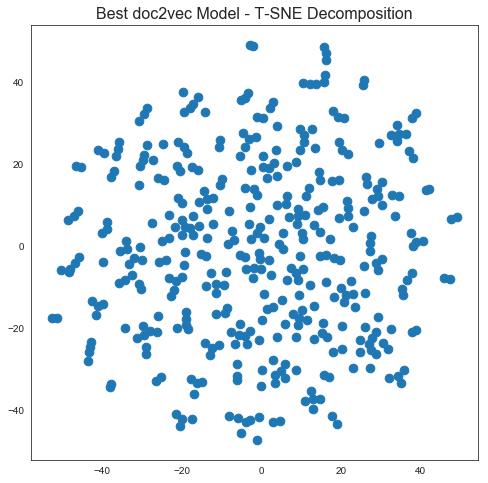

In [17]:
# PCA because it's recommended to decompose to ~50 components prior to TSNE
pca = PCA(n_components=50)
df_docvec_pca = pca.fit_transform(df_docvec)

# Scaling the data because T-SNE requires scaled data
df_docvec_pca_scaled = StandardScaler().fit_transform(df_docvec_pca)


# Instantiating the T-SNE decomposition
tsne = TSNE(n_iter=10000, 
            n_iter_without_progress=300, 
            perplexity=5,
            learning_rate=10,
            random_state=r
           )
vec_tsne = tsne.fit_transform(df_docvec_pca_scaled)

# Plotting the T-SNE data
plt.figure(figsize=(8,8))
plt.scatter(vec_tsne[:, 0], 
            vec_tsne[:, 1], 
            s=75)
plt.title('Best doc2vec Model - T-SNE Decomposition', size=16)
plt.show()

Our model does not form nice, dense, convex clusters.  It's more a loose aglomeration of data points than clusters, really.  However, there is structure to this data.  In fact, it seems like we might have *many* topics clustering nicely.  One thing to be wary of though is that if we do have lots of small clusters, we will likely overfit the data by introducing many clusters.  Let's evaluate.

## Clustering

We'll quickly plot up a range of potential clustering results.  Note that because we have these non-dense, non-convex clusters, we will use [Gaussian Mixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) as our clustering algorithm.  It handles these cases nicely.

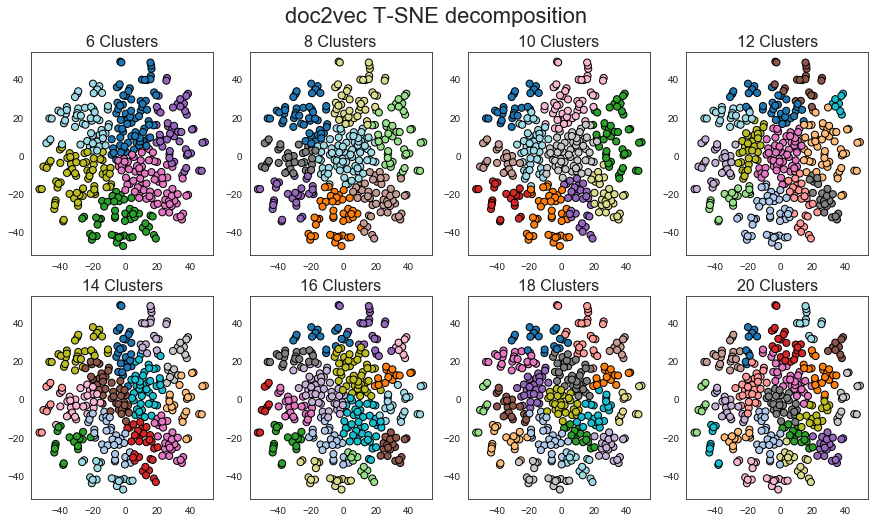

In [18]:
n_comp = [x for x in range(6,22,2)]

plt.figure(figsize=(15,8))
plt.suptitle('doc2vec T-SNE decomposition', size=22)

for i, n in enumerate(n_comp):
    
    gm = GaussianMixture(n_components=n, random_state=r)
    gm_pred = gm.fit_predict(vec_tsne)
    
    title = str(n) + ' Clusters'
    
    # Plotting the T-SNE data
    plt.subplot(2,4,(i+1))
    plt.scatter(vec_tsne[:, 0], 
                vec_tsne[:, 1], 
                s=50, 
                c=gm_pred,
                cmap='tab20',
                edgecolors='k')
    plt.title(title, size=16)
    
plt.subplots_adjust(top=.9)
plt.show()

A quick visual inspection shows that more clusters seem like a better choice than fewer, but we should quantify this by using a clustering evalaution metric.

Silhoutte score is a common similarity metric for evaluating clusters, however, it works best on dense, convex data.  Obviously, our clusters are generally not convex nor dense.  The **Davies-Bouldin Index** is a different similarity metric which will work better for this non-convex data.  This measure uses two different distances for computation: 1) the average distance between each point of cluster $i$ and the centroid of that cluster, and 2) the distance between cluster centroids $i$ and $j$.  A lower Davies-Bouldin index relates to a model with better separation between clusters.  Zero is the lowest possible score.

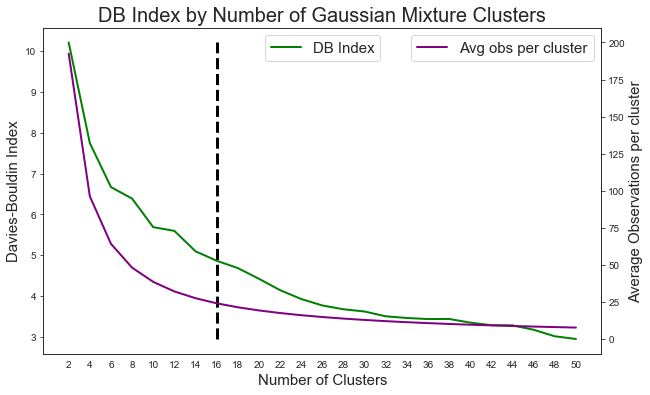

In [19]:
# Iterating through a range of number of clusters and plotting the results

num_clusters = [x for x in range(2,51,2)]
db_index = [] 
avg_obs = []

for no in num_clusters:
    # Fit & predict the gaussian mixture clusters
    gm_pred = GaussianMixture(n_components=no, random_state=r).fit_predict(vec_tsne)
    
    # Calculate the Davies-Bouldin Index
    db_index.append(davies_bouldin_score(df_docvec_pca_scaled, gm_pred))
    
    # Calculate the mean number of points in each cluster
    avg_obs.append(pd.value_counts(gm_pred).mean())


#Visualize Results
fig, ax = plt.subplots(figsize=(10,6))
ax2 = ax.twinx()
ax = sns.lineplot(num_clusters, db_index, 
                  color='g', label='DB Index', 
                  linewidth=2, ax=ax)
ax2 =sns.lineplot(num_clusters, avg_obs, 
                  color='purple', label='Avg obs per cluster', linewidth=2)
ax.set_ylabel('Davies-Bouldin Index',fontsize=15)
ax.set_xlabel('Number of Clusters',fontsize=15)
ax.legend(loc='upper center',fontsize=15)
ax2.legend(loc='upper right',fontsize=15)
plt.ylabel('Average Observations per cluster',fontsize=15)
plt.title('DB Index by Number of Gaussian Mixture Clusters',fontsize=20)
plt.xticks(num_clusters, size=14)
plt.vlines(x=16, ymin=0, ymax=200, colors='k', linestyles='--', linewidth=3)
plt.show()

Using a scree-plot method, we'll choose 16 as the optimal number of clusters.  While the DB Index gets progressively better with an increasing number of clusters, the number of points per cluster decreases significantly.  This will tend to overfit the resulting model.  As a compromise we choose a midpoint of sorts between the elbow of the observation count per cluster and the DB Index curves.

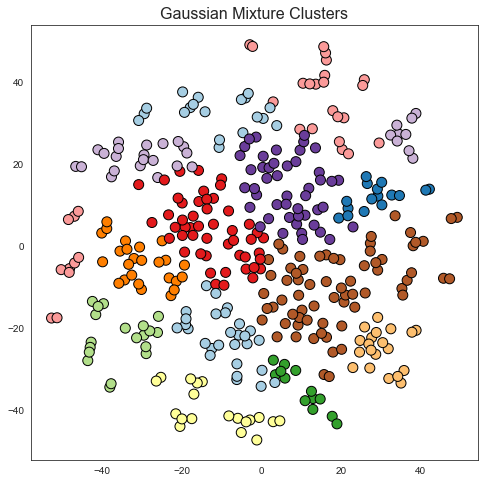

In [20]:
# Final cluster plot
    
gm = GaussianMixture(n_components=16, random_state=r)
gm_pred = gm.fit_predict(vec_tsne)

# Plotting the T-SNE data
plt.figure(figsize=(8,8))
plt.scatter(vec_tsne[:, 0], 
            vec_tsne[:, 1], 
            s=100, 
            c=gm_pred,
            cmap='Paired',
            edgecolors='k')
plt.title('Gaussian Mixture Clusters', size=16)
plt.show()

## Cluster Evaluation

While using DB Index is a nice quantitative way to evaluate the geometry of the cluster result, it doesn't necessarily have any information about our actual TED Talks.  We'll have to reconstruct our orginial data frame with just the training data to get a look at this information.

In [21]:
# Creating a "training" dataframe
df_vid_train = pd.concat([df_vid.iloc[[i]] for i in X_train_idx], ignore_index=True, sort=False)

print(df_vid_train.shape)
df_vid_train.head()

(385, 10)


,ids,title,tags,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,transcript,clean_tags
0,aRcD31sA2a0,3 ways to build a happy marriage and avoid div...,"['TEDTalk', 'TEDTalks', 'TEDx', 'Love', 'Human...",199659,4533,304,0,447,"Almost 50 years ago, psychiatrists Richard Rah...","[Love, Humanity, Relationships, Community, Dec..."
1,twG4mr6Jov0,What you can do to prevent Alzheimer&#39;s | L...,"['TEDTalk', 'TEDTalks', 'Lisa Genova', 'Still ...",1327993,20730,819,0,1209,How many people here would like to live to be ...,"[LisaGenova, StillAlice, Alzheimers, aging, bi..."
2,druJDI6hiiY,Why helmets don&#39;t prevent concussions -- a...,"['TED Talk', 'TED Talks', 'David Camarillo', '...",181572,2975,92,0,288,The word concussion evokes a fear these days m...,"[DavidCamarillo, helmets, concussion, concussi..."
3,fxbCHn6gE3U,The surprising habits of original thinkers | A...,"['TED Talk', 'TED Talks', 'Adam Grant', 'origi...",4505565,103063,1867,0,2834,"Seven years ago, a student came to me and aske...","[AdamGrant, originals, creatives, originalthin..."
4,V1yW5IsnSjo,Why domestic violence victims don&#39;t leave ...,"['TEDTalk', 'TEDTalks', 'TED Talk', 'TED Talks...",2321094,28982,994,0,4917,'m here today to talk about a disturbing ques...,"[culture, globalissues, love, relationships, v..."


In [22]:
# Adding the T-SNE coordinates and cluster label to the DataFrame
df_vid_train['TSNE-x'] = vec_tsne[:, 0]
df_vid_train['TSNE-y'] = vec_tsne[:, 1]
df_vid_train['Cluster'] = gm_pred

In [23]:
df_vid_train['Cluster'].value_counts()

7     49
12    47
14    46
1     28
9     25
15    22
6     22
11    21
8     20
13    19
3     19
0     19
2     16
4     13
5     10
10     9
Name: Cluster, dtype: int64

Ok, so we have clusters ranging in size from 12 (Cluster 5) to 40 (Cluster 0).  Let's spot check a random cluster by inspecting it's YouTube tags and the first 1000 characters of each transcript.

In [24]:
# Manually inspecting the YouTube tags in each cluster of videos
for tags in df_vid_train['clean_tags'][df_vid_train['Cluster'] == 12]:
    print(tags, '\n')

['Science', 'Technology', 'ChangeChange', 'Universe', 'Sustainability', 'Energy', 'Electricity'] 

['Martin', 'Seligman', 'talks', 'positive', 'psychology', 'good', 'engagement', 'philanthropy', 'altruism', 'happiness', 'meaning'] 

['Eli', 'Pariser', 'talks', 'personalized', 'web', 'browsing', 'recommendations', 'filter', 'bubble', 'bubbles', 'information', 'democracy', 'reddit', 'google', 'facebook'] 

['Anthony', 'Atala', 'Tony', 'talks', 'regenerative', 'medicine', 'health', 'organ', 'tissue', 'Wake', 'Forest', 'Institute', 'stem', 'cells'] 

['Internet', 'Community', 'Compassion', 'Politics', 'Race'] 

['TaylorWilson', 'innovation', 'nuclearenergy', 'physics', 'science', 'technology', 'youth'] 

['Moon', 'Astronomy', 'Beauty', 'Nature', 'SolarSystem', 'Science'] 

['Patricia', 'Kuhl', 'talks', 'language', 'learning', 'psychology', 'children', 'linguistics', 'babies', 'brain', 'mind', 'statistics'] 

['Guns', 'UnitedStates', 'Activism', 'Mentalhealth', 'Mind', 'Pain', 'Parenting', 

Well...these tags seem all over the place.  There are some clear major topics like Society, Culture, Science, and Work.  But, they aren't super targeted.

In [25]:
# Manually inspecting the first 1000 characters of each cluster of videos
for trans in df_vid_train['transcript'][df_vid_train['Cluster'] == 12]:
    print(trans[:1000], '\n')

Every summer when I was growing up, I would fly from my home in Canada to visit my grandparents, who lived in Mumbai, India. Now, Canadian summers are pretty mild at best  about 22 degrees Celsius or 72 degrees Fahrenheit is a typical summer's day, and not too hot. Mumbai, on the other hand, is a hot and humid place well into the 30s Celsius or 90s Fahrenheit. As soon as I'd reach it, I'd ask, "How could anyone live, work or sleep in such weather?" To make things worse, my grandparents didn't have an air conditioner. And while I tried my very, very best, I was never able to persuade them to get one. But this is changing, and fast. Cooling systems today collectively account for 17 percent of the electricity we use worldwide. This includes everything from the air conditioners I so desperately wanted during my summer vacations, to the refrigeration systems that keep our food safe and cold for us in our supermarkets, to the industrial scale systems that keep our data centers operational. C

Scanning through the actual transcripts makes this even more clear. There is some similarity between multiple videos in each cluster, however, they tend to cover many different topics.  

This number of clusters (16) appear like it is too big to be accurately grouping the talks into like cohesive topics.  Perhaps we could increase the number of clusters, however, as mentioned above, this will probably lead to severe overfitting. 

# Popularity metric

Even though we don't have great clustering results, it might be semi-interesting to look at the popularity of videos.  We'll transform our YouTube stats into a metric.

In [26]:
# Creating a Like:Dislike ratio.  Adding one to dislikes to eliminate a div by zero error
df_vid_train['likeDislikeRatio'] = df_vid_train['likeCount'] / (df_vid_train['dislikeCount'] + 1)

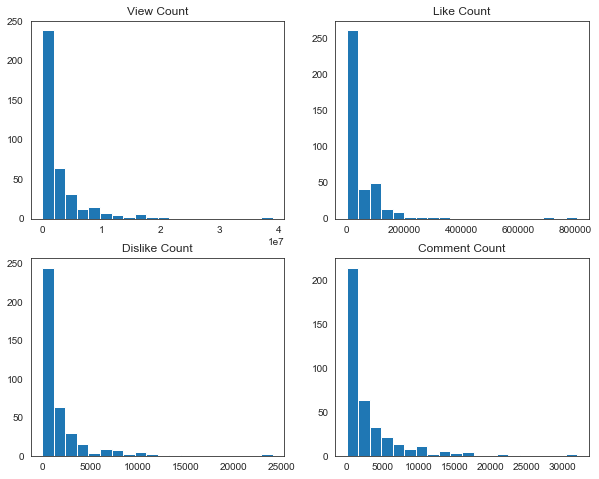

In [27]:
# Plotting the distributions of our popularity stats

plt.figure(figsize=(10,8))

plt.subplot(221)
plt.hist(df_vid_train['viewCount'], bins=20)
plt.title('View Count')

plt.subplot(222)
plt.hist(df_vid_train['likeCount'], bins=20)
plt.title('Like Count')

plt.subplot(223)
plt.hist(df_vid_train['dislikeCount'], bins=20)
plt.title('Dislike Count')

plt.subplot(224)
plt.hist(df_vid_train['commentCount'], bins=20)
plt.title('Comment Count')

plt.show()

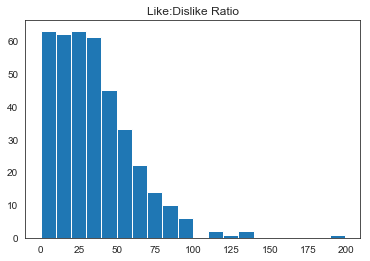

In [28]:
plt.title('Like:Dislike Ratio')
plt.hist(df_vid_train['likeDislikeRatio'], bins=20)
plt.show()

These stats look sort of log-normal.  Let's see what the log-transforms look like.

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


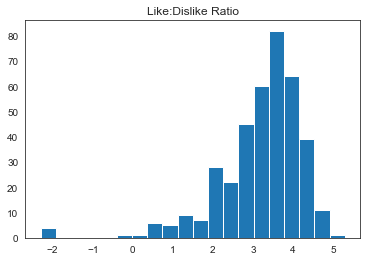

In [29]:
# Resetting minimum value from 0 to 0.1 to eliminate future div by 0 errors
# The lowest non-zero ratio is ~.19
df_vid_train['likeDislikeRatio'][df_vid_train['likeDislikeRatio'] == 0] = .1

plt.title('Like:Dislike Ratio')
plt.hist(np.log(df_vid_train['likeDislikeRatio']), bins=20)
plt.show()

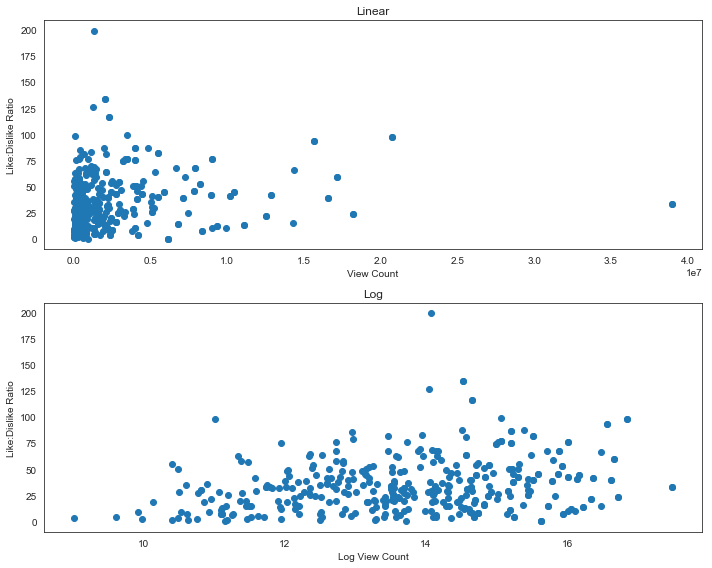

In [30]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.scatter(df_vid_train['viewCount'], df_vid_train['likeDislikeRatio'])
plt.xlabel('View Count')
plt.ylabel('Like:Dislike Ratio')
plt.title('Linear')

plt.subplot(212)
plt.scatter(np.log(df_vid_train['viewCount']), df_vid_train['likeDislikeRatio'])
plt.xlabel('Log View Count')
plt.ylabel('Like:Dislike Ratio')
plt.title('Log')

plt.tight_layout()
plt.show()

Indeed, when we do a log-transform of both like:dislike ratio and view count, we observe more normal distributions.

## Popularity Metric

In [31]:
# Create a Popularity metric based on views and like:dislike vote ratio
df_vid_train['Popularity'] = (np.log(df_vid_train['viewCount']) / max(np.log(df_vid_train['viewCount']))
                             ) * (np.log(df_vid_train['likeDislikeRatio']
                                        ) / max(np.log(df_vid_train['likeDislikeRatio'])))

# Eliminating the few negative scores
df_vid_train['Popularity'] = np.where((df_vid_train['Popularity'] < 0), 0, df_vid_train['Popularity'])

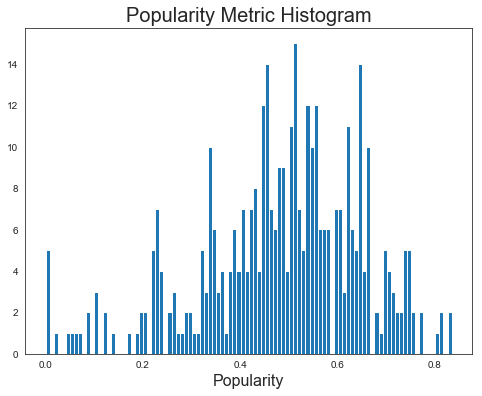

In [32]:
plt.figure(figsize=(8,6))

plt.hist(df_vid_train['Popularity'], bins=100)
plt.title('Popularity Metric Histogram', size=20)
plt.xlabel('Popularity', size=16)
plt.show()

In [33]:
df_vid_train['Popularity'].describe()

count    385.000000
mean       0.482481
std        0.165780
min        0.000000
25%        0.396509
50%        0.502559
75%        0.601024
max        0.834130
Name: Popularity, dtype: float64

We now have a normally-distributed `Popularity` metric.

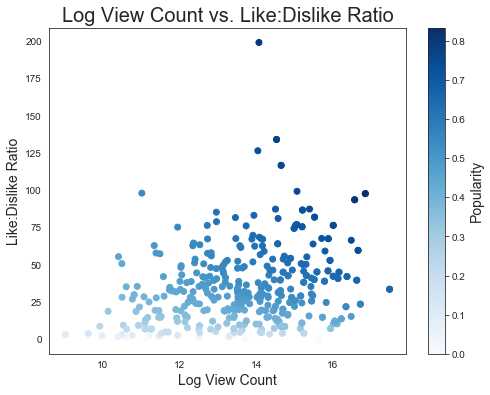

In [34]:
plt.figure(figsize=(8,6))

plt.scatter(np.log(df_vid_train['viewCount']), 
            df_vid_train['likeDislikeRatio'], 
            c=df_vid_train['Popularity'], 
            cmap='Blues')
plt.xlabel('Log View Count', size=14)
plt.ylabel('Like:Dislike Ratio', size=14)
plt.title('Log View Count vs. Like:Dislike Ratio', size=20)
plt.colorbar().ax.set_ylabel('Popularity', size=14)

plt.show()

Great.  Now we have a Popularity metric that evenly weights a video's like:dislike ratio and it's total view count.  Let's plot our clusters again with this metric applied to the marker size parameter.

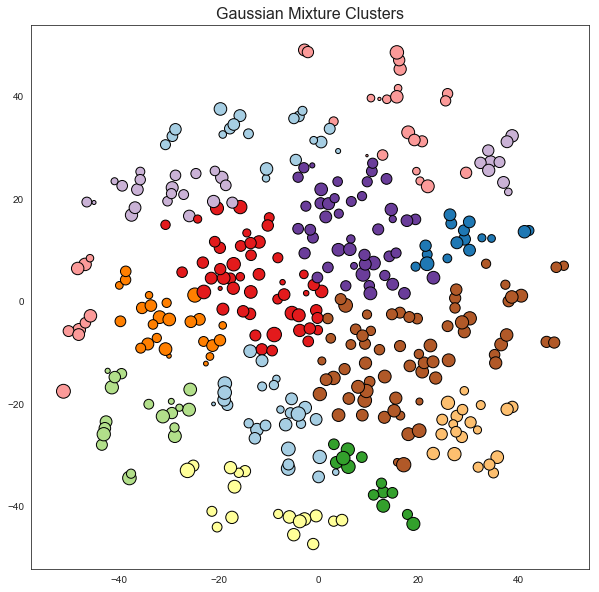

In [35]:
# Plotting the T-SNE data
plt.figure(figsize=(10,10))
plt.scatter(df_vid_train['TSNE-x'],
            df_vid_train['TSNE-y'], 
            s=df_vid_train['Popularity'] * 250, 
            c=df_vid_train['Cluster'],
            cmap='Paired',
            edgecolors='k')
plt.title('Gaussian Mixture Clusters', size=16)
plt.show()

It looks, superficially, that most of the clusters have a range of popular and unpopular videos.  None of the groups really jump out as super popular topics, but let's interrogate this thought.

In [36]:
df_vid_train.groupby('Cluster')['Popularity'].mean().sort_values()

Cluster
6     0.424662
0     0.426199
9     0.431666
11    0.439101
12    0.448984
2     0.472250
8     0.484374
3     0.491685
7     0.494576
5     0.497689
1     0.510917
10    0.514029
13    0.514059
14    0.514253
15    0.536078
4     0.558073
Name: Popularity, dtype: float64

Cluster 4 stands out as a popular group while Cluster 8 is the least popular.

In [37]:
df_vid_train['Cluster'].value_counts().sort_index()

0     19
1     28
2     16
3     19
4     13
5     10
6     22
7     49
8     20
9     25
10     9
11    21
12    47
13    19
14    46
15    22
Name: Cluster, dtype: int64

Cluster 4 has a pretty small number of samples while Cluster 8 has a large number of samples.  Perhaps we shouldn't read too much into Cluster 4's `Popularity` metric.  But let's check it's tags to see if they are a legitimately clustered topic.

# Results

These model results are not great.  While the model seems to have been trained ok and returns seemingly relevent `.most_similar()` talks we don't get good clustering results.  There are several potential reasons:

1. TED Talks are intentionally vague
  - As mentioned in the introduction, TED Talks are not pointedly about certain topics.  They attack major discussion points obliquely, through the lens of a personal or cultural anecdote, never head on.  This obfuscation is a detriment when trying to use semantic embeddings.  
2. The corpus is not large enough
  - We have 500+ talks, but the TED Talk website boasts of over 3100 talks.  Including more would obviously help.  Both in having more potential training material, but also in having more potential topics to cluster or more dense clusters to create.
3. The model grid search was flawed.
  - While we were most concerned with how we humans parse the text, we used the T-SNE result as grid search metric.